In [9]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import time
import pickle
import numpy as np
import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.registrationdata as regdata
import defmod.hamiltonian_multishape as hamiltonian
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
from defmod import optimize
import defmod.save_res as results



torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data1 = regdata.Nut_translated(source_transvec=[0.,0.], target_transvec=[-1.,0.], reflect_target=-1., undersample=2)
data1()
data2 = regdata.Nut_translated(source_transvec=[1.,1.5], target_transvec=[1.5,1.5], reflect_target=1., undersample=2)
data2()
source = [*data1.source, *data2.source]
target = [*data1.target, *data2.target]
module_list = [*data1.modules, *data2.modules]
reduce_background = False

In [ ]:
plt.figure()
c = ['r', 'b']
for i in range(2):
    plt.figure()
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1], c=c[i])
    for j in range(5):
        plt.scatter(module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,1], c=c[i])

    plt.plot(target[i].detach().numpy()[:,0], target[i].detach().numpy()[:,1], c=c[i])


    for gd in module_list[i].manifold.gd:
        plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='r')
    for gd in module_list[i].manifold.gd:
        plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='b')

#plt.show()

In [ ]:
plt.figure()
c = ['r', 'b']

plt.figure()
for i in range(2):
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1], c=c[i])
    
plt.figure()
for i in range(2):
    for j in range(5):
        plt.scatter(module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[i][j].manifold.gd.view(-1,2).detach().numpy()[:,1], c=c[i])

plt.figure()        
for i in range(2):
    plt.plot(target[i].detach().numpy()[:,0], target[i].detach().numpy()[:,1], c=c[i])

plt.show()

In [ ]:
sigma_bg = 0.3
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr)
def attach(modules, target):
    
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i][0].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])
E = EnergyFunctional_unconstrained(H.module, H, source, target, dim=2, gamma=1e-3, attach=attach)

In [ ]:
attach(H.module, target)

In [ ]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

from defmod import optimize
tic = time.time()
X[1], iter_states = optimize.CG(E, X, disp=True)(maxiter=500)
toc=time.time()

In [ ]:
toc-tic

In [ ]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()

In [ ]:
import defmod.save_res as results

In [ ]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
save = results.Save_Results_MultiShape(H, source, target, E, iter_states=iter_states, time=toc-tic)

xlim = [-4.5, 5.5]
ylim = [-2.5,3.5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

In [ ]:
fig_states = save.fig_states(show=True)
fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grid(True)

In [ ]:
save.save('../results/Nuts-Multi/MultiShapeDefmod/', axeslim=[xlim, ylim] , plot_gd=['plot', 'scatter', 'scatter', 'scatter', None])
plt.close('all')

In [11]:
gd0 = torch.cat([data1.modules[0][i].manifold.gd.clone() for i in [1,2,3]]).view(-1)
gd1= torch.cat([data2.modules[0][i].manifold.gd.clone() for i in [1,2,3]]).view(-1)
silent_gd0 = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, 3, gd=gd0))
silent_gd1 = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, 3, gd=gd1))

In [12]:
## LDDMM Multishape Module
sigma1 = 1
manifold1 = dm.manifold.Landmarks(2, len(source[0]), gd=source[0].view(-1))
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

mod1 = dm.deformationmodules.CompoundModule([silent1, silent_gd0, trans1])

sigma2 = 1
manifold2 = dm.manifold.Landmarks(2, len(source[1]), gd=source[1].view(-1))
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

mod2 = dm.deformationmodules.CompoundModule([silent2, silent_gd1, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.2
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

In [13]:
def attach(modules, target):
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i][0].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])


In [23]:
Energy_multi_LDDMM = EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=1e-3, attach = attach)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]

tic=time.time()
X_multi_LDDMM[1], iter_states = dm.optimize.Newton(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=500)
toc=time.time()

In [ ]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])
H_multi_LDDMM.geodesic_controls()
save = results.Save_Results_MultiShape(H_multi_LDDMM, source, target, Energy_multi_LDDMM, time=toc-tic, iter_states=iter_states)

In [ ]:
xlim = [-3, 4]
ylim = [-2,4]
d = [0.1, 0.1]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)
save.save('../results/Nuts-Multi/MultiShapeLDDMM/',axeslim=[xlim, ylim] , plot_gd=['plot', 'scatter', None])
plt.close('all')

In [32]:
p = pickle.load( open( '../results/Nuts-Multi/MultiShapeLDDMM/params.p', "rb" ) )

#p['Hamiltonian'].module.manifold.gd


In [38]:
torch.tensor(p['iter_states'][-1])

tensor([-2.1666e-01, -3.3353e-02, -2.2394e-01, -4.2499e-03, -1.9106e-01,
         4.8051e-03, -1.4936e-01, -5.3854e-03, -9.2945e-02, -3.5259e-02,
        -4.6130e-02, -7.4058e-02, -5.5504e-03, -1.2887e-01,  4.7868e-03,
        -1.6647e-01, -4.2346e-03, -1.8156e-01, -2.1605e-02, -1.7498e-01,
        -3.7972e-02, -1.4971e-01, -4.5298e-02, -1.0937e-01, -4.2119e-02,
        -7.6955e-02, -3.1326e-02, -4.2371e-02, -1.7229e-02, -1.7359e-02,
        -7.1424e-03, -9.3948e-03, -1.0011e-02, -9.6561e-03, -6.7898e-03,
        -4.2798e-03,  2.4813e-03, -5.4110e-03,  1.0590e-02, -1.0607e-02,
         1.3923e-02, -1.7723e-02,  1.0292e-02, -2.3145e-02, -1.3445e-04,
        -3.1814e-02, -1.5525e-02, -4.6055e-02, -3.7459e-02, -6.6965e-02,
        -7.9979e-02, -9.8297e-02, -1.1543e-01, -1.1381e-01, -1.6509e-01,
        -1.2055e-01, -2.0762e-01, -1.1185e-01, -2.5338e-01, -8.0685e-02,
        -2.7789e-01, -3.7641e-02, -2.7801e-01,  2.4582e-02, -2.4703e-01,
         7.2480e-02, -2.1010e-01,  9.3389e-02, -1.5

In [39]:
E = p['Energyfunctional'].energy(torch.cat(p['Hamiltonian'].module.manifold.unroll_gd()), torch.tensor(p['iter_states'][-1]))


TypeError: shoot() takes 1 positional argument but 3 were given

In [25]:
## LDDMM Module

manifold1 = dm.manifold.Landmarks(2, len(source[0]), gd=source[0].view(-1))
manifold2 = dm.manifold.Landmarks(2, len(source[1]), gd=source[1].view(-1))
translations = [dm.deformationmodules.Translations(man, sigma=0.3) for man in [manifold1, manifold2]]
module_LDDMM = dm.deformationmodules.CompoundModule([*translations, silent_gd0, silent_gd1])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])


reg_param = 1e-3
Energy_LDDMM = EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, source, target, dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

tic=time.time()
X_LDDMM[1], iter_states = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=2500)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 38.998647609359494
cost: 0.0 attach: 38.998647609359494
cost: 0.0031811301325177068 attach: 37.57002396605616
cost: 0.0031811301325177068 attach: 37.57002396605616
cost: 2.4140836062904556e-05 attach: 37.19360186246416
cost: 2.4140836062904556e-05 attach: 37.19360186246416
cost: 0.00017427143805638754 attach: 33.68097111273934
cost: 0.00017427143805638754 attach: 33.68097111273934
cost: 0.00236641452812784 attach: 23.53644511403291
cost: 0.00236641452812784 attach: 23.53644511403291
cost: 0.014121564215290015 attach: 27.307383168192537
cost: 0.014121564215290015 attach: 27.307383168192537
cost: 0.006649235765366539 attach: 14.706533485481527
cost: 0.006649235765366539 attach: 14.706533485481527
cost: 0.016937371154256732 attach: 248.3280083321803
cost: 0.016937371154256732 attach: 248.3280083321803
cost: 0.009195539871478996 attach: 12.01228517115124
cost: 0.009195539871478996 attach: 12.01228517115124
cost: 0.012258780883318752 attach: 11.318871736075558
cost: 0.0122

cost: 0.019562119007103466 attach: 2.1173534355568115
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.01956211900710347 attach: 2.1085244902510034
cost: 0.01956211900710347 attach: 2.1085244902510034
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.01956211900710345 attach: 856238.2243135662
cost: 0.01956211900710345 attach: 856238.2243135662
cost: 0.019562119007103515 attach: 2.0483128028940403
cost: 0.019562119007103515 attach: 2.0483128028940403


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.01951849303370795 attach: 2.0775753143588513
cost: 0.019545481988272634 attach: 2.0846772541120266
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019479388383800908 attach: 627.4316395621674
cost: 0.019479388383800908 attach: 627.4316395621674
cost: 0.01955821914951136 attach: 2.0873010304144035
cost: 0.01955821914951136 attach: 2.0873010304144035
cost: 0.019558219583657867 attach: 2.195633575526191
cost: 0.019558219583657867 attach: 2.195633575526191
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.019558219583658186 attach: 1.9758129885284141
cost: 0.019558219583658186 attach: 1.9758129885284141
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365841 attach: 1.9693607784219402
cost: 0.01955821958365828 attach: 2.0564734799346436
cost: 0.01955821958365828 attach: 2.0564734799346436
cost: 0.01955821958365841 attach: 1.96936077

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.019479388383800908 attach: 627.4316395621674
cost: 0.019517129446596174 attach: 2.385813832249715
cost: 0.0195305296417378 attach: 2.1783030992804466
cost: 0.019555350024366095 attach: 2.0284645428902177
cost: 0.019556782909113044 attach: 2.0049320141193423
cost: 0.019557500772660944 attach: 2.098761430222238
cost: 0.019557860059728496 attach: 80190.57186755777
cost: 0.019558039792085598 attach: 2.0860828707000234
cost: 0.0195580997167287 attach: 2.089062041716897
cost: 0.019558159646903744 attach: 2.0810939014239747
cost: 0.019558189614458633 attach: 2.087851408888266
cost: 0.019558204598852914 attach: 2.09701030732351
         Current function value: 1.988919
         Iterations: 43
         Function evaluations: 113
         Gradient evaluations: 99


In [ ]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target, Energy_LDDMM, time=toc-tic, iter_states=iter_states)

xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

In [ ]:
save.save('../results/Nuts-Multi/LDDMM/', axeslim=[*xlim, *ylim] , plot_gd=['plot', 'plot', 'scatter', 'scatter', None])
plt.close('all')

In [43]:
p = pickle.load( open( '../results/Nuts-Multi/LDDMM/params.p', "rb" ) )
p['Hamiltonian'].module.module_list

In [ ]:
toc-tic

In [45]:
data1 = regdata.Nut_translated(source_transvec=[0.,0.], target_transvec=[0.,0.], reflect_target=-1., undersample=2)
data1()
data2 = regdata.Nut_translated(source_transvec=[1.,3.], target_transvec=[1.,3.], reflect_target=1., undersample=2)
data2()
source = [*data1.source, *data2.source]
target = [*data1.target, *data2.target]
module_list = [*data1.modules, *data2.modules]
reduce_background = False

In [46]:
## Unconstrained Compound Module

module_compound = dm.deformationmodules.CompoundModule([*data1.modules, *data2.modules])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

def attach(modules, target): 
    return sum([dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[5*i].manifold.gd.view(-1,2)], [target[i]]) for i in range(2)])

Energy_compound = EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=1e-3, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

In [47]:
attach(H_compound.module, target)

tensor(25.8647, grad_fn=<AddBackward0>)

In [48]:
tic=time.time()
X_compound[1], iter_states = dm.optimize.BFGS(Energy_compound, X_compound, disp=True)(maxiter=2000)
toc=time.time()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 25.864663228610674
cost: 0.0 attach: 25.864663228610674
cost: 0.05049736745607101 attach: 94.42458951583936
cost: 0.05049736745607101 attach: 94.42458951583936
cost: 0.001877918432571922 attach: 29.658358362765284
cost: 0.001877918432571922 attach: 29.658358362765284
cost: 0.0003428408125599957 attach: 16.042914836464842
cost: 0.0003428408125599957 attach: 16.042914836464842
cost: 0.004116165556497807 attach: 23.306936164203883
cost: 0.004116165556497807 attach: 23.306936164203883
cost: 0.0008022456541918532 attach: 13.432447857313242
cost: 0.0008022456541918532 attach: 13.432447857313242
cost: 0.056594169458584455 attach: 91.5907354933645
cost: 0.056594169458584455 attach: 91.5907354933645
cost: 0.0008099756581336312 attach: 13.450714573454071
cost: 0.0008099756581336312 attach: 13.450714573454071
cost: 0.0008035680488113562 attach: 13.421284109416401
cost: 0.0008035680488113562 attach: 13.421284109416401
cost: 0.0008042252149737106 attach: 13.398829731680927
cost: 0

cost: 0.019588838766435017 attach: 0.007142318305293216
cost: 0.01959332942276373 attach: 0.007012720802796579
cost: 0.01959332942276373 attach: 0.007012720802796579
cost: 0.019603561594856822 attach: 0.006874862374349533
cost: 0.019603561594856822 attach: 0.006874862374349533
cost: 0.019605252793744747 attach: 0.0067378633554060485
cost: 0.019605252793744747 attach: 0.0067378633554060485
cost: 0.01960576295757787 attach: 0.006630692755386747
cost: 0.01960576295757787 attach: 0.006630692755386747
cost: 0.019600508365508428 attach: 0.006553960782531121
cost: 0.019600508365508428 attach: 0.006553960782531121
cost: 0.019592461606739952 attach: 0.006497495094622607
cost: 0.019592461606739952 attach: 0.006497495094622607
cost: 0.019585512384252247 attach: 0.006423873074441033
cost: 0.019585512384252247 attach: 0.006423873074441033
cost: 0.019576505535587756 attach: 0.006342711464959905
cost: 0.019576505535587756 attach: 0.006342711464959905
cost: 0.019569205749158283 attach: 0.0062465423376

cost: 0.01925410915050404 attach: 0.0036488831640415498
cost: 0.01925410915050404 attach: 0.0036488831640415498
cost: 0.019249761680081377 attach: 0.0036293103751319222
cost: 0.019249761680081377 attach: 0.0036293103751319222
cost: 0.0192558777730206 attach: 0.0035977301105774018
cost: 0.0192558777730206 attach: 0.0035977301105774018
cost: 0.019243065722117945 attach: 0.003584130817010589
cost: 0.019243065722117945 attach: 0.003584130817010589
cost: 0.019229557605014123 attach: 0.0035690928093963237
cost: 0.019229557605014123 attach: 0.0035690928093963237
cost: 0.019224365649326117 attach: 0.0035533884087115553
cost: 0.019224365649326117 attach: 0.0035533884087115553
cost: 0.019215823700768565 attach: 0.0035316233984197254
cost: 0.019215823700768565 attach: 0.0035316233984197254
cost: 0.019211008158741927 attach: 0.0035057658108748058
cost: 0.019211008158741927 attach: 0.0035057658108748058
cost: 0.01920064887560896 attach: 0.003495138403902587
cost: 0.01920064887560896 attach: 0.00349

cost: 0.018706267951613433 attach: 0.002884734437399672
cost: 0.01870192824234771 attach: 0.0028779088896087046
cost: 0.01870192824234771 attach: 0.0028779088896087046
cost: 0.01869770828969584 attach: 0.0028755286068875563
cost: 0.01869770828969584 attach: 0.0028755286068875563
cost: 0.018695444565855146 attach: 0.0028721365848909386
cost: 0.018695444565855146 attach: 0.0028721365848909386
cost: 0.018690830425726255 attach: 0.002869009432103553
cost: 0.018690830425726255 attach: 0.002869009432103553
cost: 0.01868184424332014 attach: 0.0028660808048659447
cost: 0.01868184424332014 attach: 0.0028660808048659447
cost: 0.018669968604602724 attach: 0.002860006320670294
cost: 0.018669968604602724 attach: 0.002860006320670294
cost: 0.018656500668981776 attach: 0.002851685392126768
cost: 0.018656500668981776 attach: 0.002851685392126768
cost: 0.01865288732548379 attach: 0.0028375733372829615
cost: 0.01865288732548379 attach: 0.0028375733372829615
cost: 0.018637101436279578 attach: 0.002851983

In [49]:
toc-tic

1740.765572309494

In [50]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
save = results.Save_Results_SingleShape(H_compound, source, target, Energy_compound, time=toc-tic, iter_states=iter_states)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


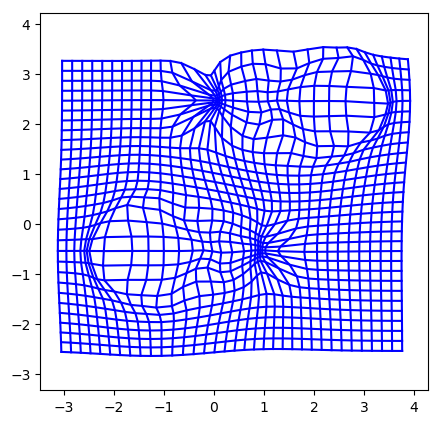

[<Figure size 500x500 with 1 Axes>]

In [52]:
xlim = [-3, 4]
ylim = [-2,4]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

#save.save('../results/Nuts-Multi/Compound/' ,axeslim = [-3.5,4.1,-2,4], plot_gd=['plot', 'plot', 'scatter', 'scatter'])

In [44]:
p = pickle.load( open( '../results/Nuts-Multi/Compound/params.p', "rb" ) )
p['Hamiltonian'].module.module_list

In [ ]:
xlim = [-4, 4.5]
ylim = [-2,3]

fig_target = plt.figure()
plt_target = plt.plot(target[0][:,0].detach().numpy(), target[0][:, 1].detach().numpy(), c='k')
plt_target = plt.plot(target[1][:,0].detach().numpy(), target[1][:, 1].detach().numpy(), c='k')
#plt.legend((plt_target[0],),('target',))
axes = plt.gca()
axes.set_xlim(xlim)
axes.set_ylim(ylim)

fig_source = plt.figure()
plt_source = plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='b')
plt_source = plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='b')
#plt.legend(( plt_source[0],),('source',))
axes = plt.gca()
axes.set_xlim(xlim)
axes.set_ylim(ylim)
plt.show()

In [ ]:
fig_source.savefig('../results/Nuts-Multi/source.png')
fig_target.savefig('../results/Nuts-Multi/target.png')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()